In [1]:
import random
from typing import Optional

import yaml
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from sklearn.metrics import f1_score
import PIL

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
# fix all seeds
seed = 42

set_seed(seed)

# Работа с данными - изображения

Загрузим данные из датасета ```CIFAR10``` и реализуем для него ```Dataset``` от торча.

Работа с картинками:
- предобработка
- построение Dataset
- аугментации
- отображение батчей для проверки преобразований

In [5]:
from cifar import load_cifar10

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000,)


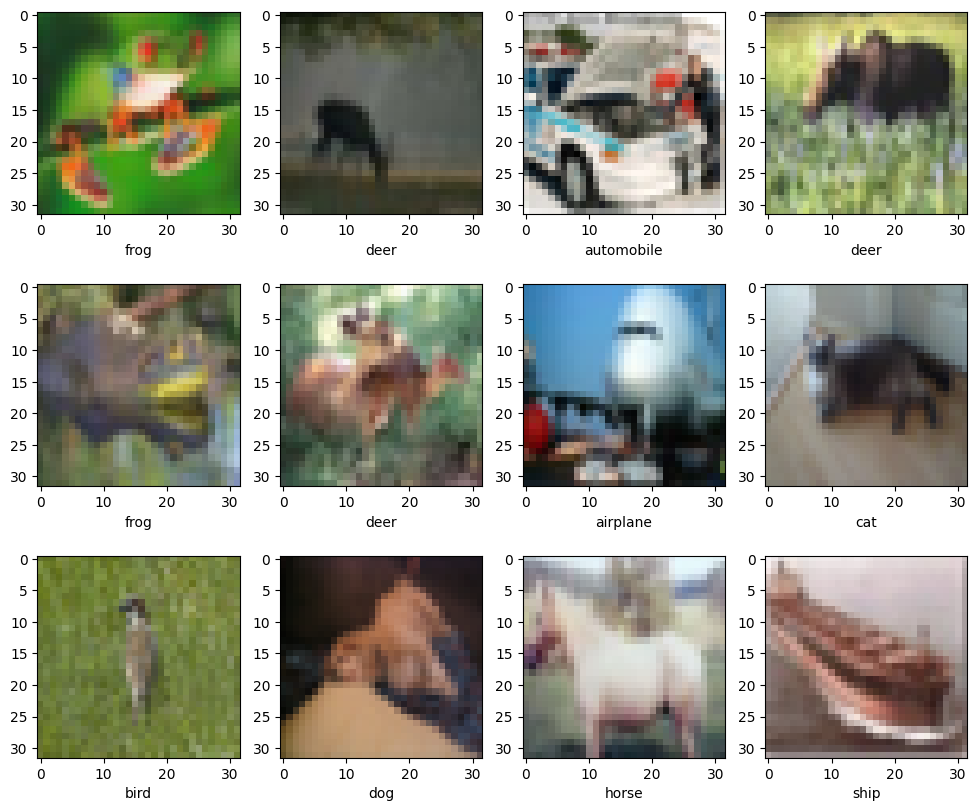

In [7]:
plt.figure(figsize=[12, 10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i], [1, 2, 0]))

## Custom Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, classes, transform_augment=None):
        self.x_data = x_data
        self.y_data = y_data
        self.cls_names = classes

        self.cls2idx = {name: idx for idx, name in enumerate(self.cls_names)}
        self.idx2cls = {idx: name for idx, name in enumerate(self.cls_names)}

        self.transform_augment = transform_augment

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, item):
        image = self.x_data[item].transpose(1, 2, 0)
        label = self.y_data[item]

        if self.transform_augment is not None:
            image = PIL.Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform_augment(image)
            image = np.array(image)

        if image.max() > 1:
            image = image / image.max()

        # image = (image - (0.5, 0.5, 0.5)) / (0.5, 0.5, 0.5)

        image = torch.tensor(image, dtype=torch.float32)
        image = image.permute(2, 0, 1)  # switch to dim, h, w

        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [9]:
transform_augment = transforms.Compose([
    transforms.RandomRotation([-30, 30]),
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
])

In [10]:
train_dataset = CustomDataset(X_train, y_train, class_names, transform_augment=transform_augment)
valid_dataset = CustomDataset(X_val, y_val, class_names, transform_augment=None)

In [11]:
batch_size = 32
n_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=n_workers)

val_loader = torch.utils.data.DataLoader(valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=n_workers)

## Проверка итераций загрузчика данных

In [12]:
img, label = next(iter(train_loader))
print(img.shape, label.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [13]:
n_classes = len(train_loader.dataset.cls2idx)
print('Количество классов:', n_classes)

Количество классов: 10


In [14]:
def plot_batch(x):
    x = x.permute(0, 2, 3, 1).numpy()

    plt.figure(figsize=[12, 10])
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(x[i])
        plt.axis('off')

    plt.tight_layout()

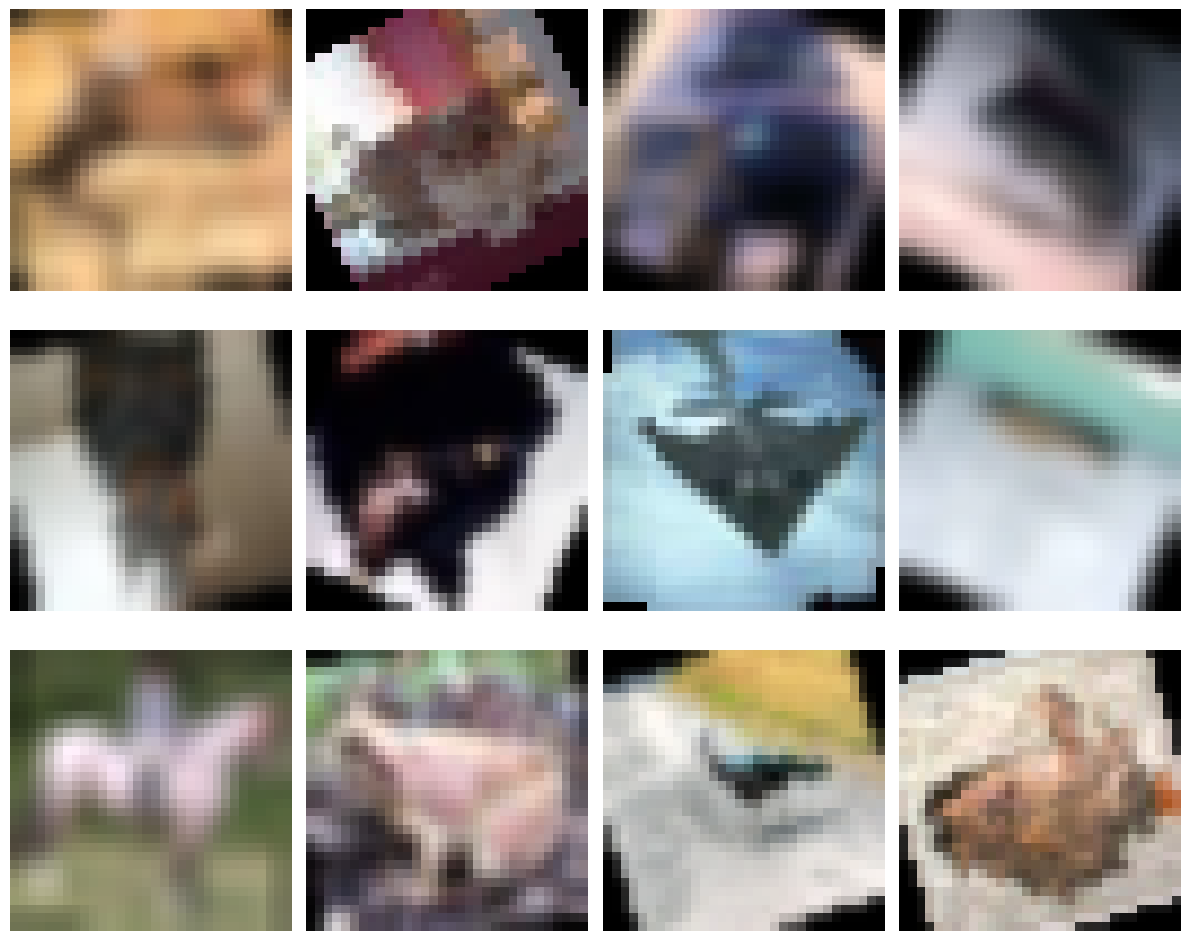

In [15]:
plot_batch(img)

# Построение модели

## Правила построения тензора

В фреймоврке ```pytorch``` размер тензор формируется следующим образом:

```python
x = torch.ones(array)
x.shape
# (bs, ch, h, w)
```

То есть: размер батча, каналы, высота, ширина. Тут речь об изображениях в качества входного тензора.

## Сверточные слои

Параметры:

| Параметр | Описание |
| --- | --- |
| in_channels | размер входа |
| out_channels | размер выхода |
| kernel_size | размер ядра |
| --- | --- |
| stride | шаг |
| padding | отступ |
| padding_mode | тип заполнения |
| dilation | разреженность |


[Convolution animations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)


```python
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
)
```

In [16]:
bs = 1
dim = 3
h = 28
w = 28
x = torch.rand((bs, dim, h, w))

print(x.shape)

torch.Size([1, 3, 28, 28])


In [17]:
simple_block = nn.Sequential(
    nn.Conv2d(in_channels=dim,
              out_channels=10,
              kernel_size=5,
              stride=1,
              padding=0,
              dilation=1,
              bias=False)
)

In [18]:
out = simple_block(x)
print(x.shape, '->', out.shape)

torch.Size([1, 3, 28, 28]) -> torch.Size([1, 10, 24, 24])


### Понимаем свертку - поиск паттерна

Посмотрим на результат свертки ядра с входным вектором на игрушечном примере. Попытаемся найти паттерн креста на следующей картинке.

In [19]:
img_path = 'cross.png'

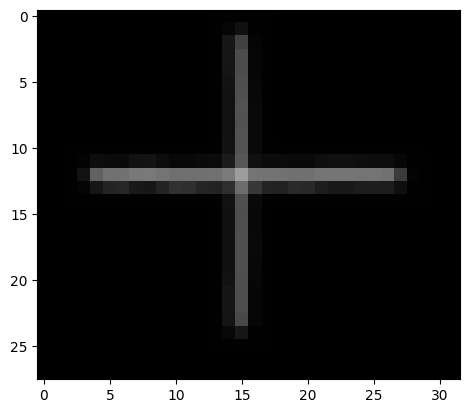

In [22]:
img = skimage.io.imread(img_path)

plt.imshow(img);

Зададим модель в виде одной свертки с входом по 3 каналам и выходом по 1. Применим такую модель к картинке и посмотрим на результат свертки.

In [23]:
conv = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5, 5), bias=False),
)

In [24]:
img_torch = torch.tensor(img / img.max(), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
img_torch.shape

torch.Size([1, 3, 28, 32])

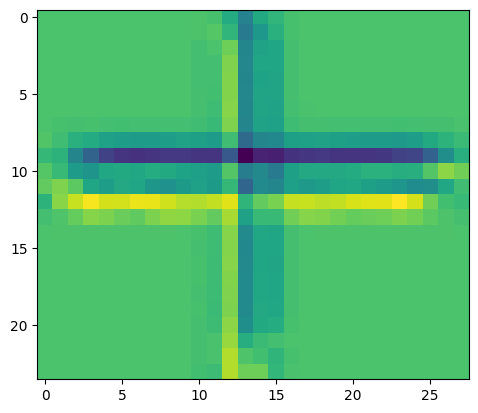

In [25]:
out = conv(img_torch)

out_map = out.squeeze().detach().numpy()
out_map = (out_map - out_map.min()) / (out_map.max() - out_map.min())

plt.imshow(out_map)
plt.show()

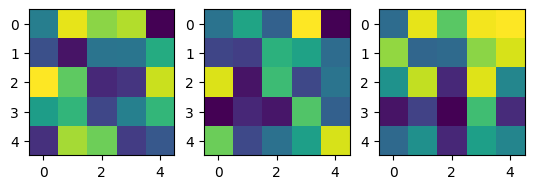

In [26]:
for i in range(3):
    m = conv[0].weight[0, i].detach().numpy()
    plt.subplot(1, 3, i + 1)
    plt.imshow(m)

### Зададим веса свертки вручную

In [27]:
simple_cross_conv = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0],
])
simple_cross_conv = np.repeat(simple_cross_conv[np.newaxis, ...], axis=0, repeats=3)
simple_cross_conv.shape

(3, 5, 5)

In [28]:
conv[0].weight = nn.Parameter(torch.tensor(simple_cross_conv, dtype=torch.float32).unsqueeze(0), requires_grad=True)

In [29]:
m = next(iter(conv.parameters()))
print(m)

Parameter containing:
tensor([[[[0., 0., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 0., 0.]],

         [[0., 0., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 0., 0.]],

         [[0., 0., 1., 0., 0.],
          [0., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.],
          [0., 1., 1., 1., 0.],
          [0., 0., 1., 0., 0.]]]], requires_grad=True)


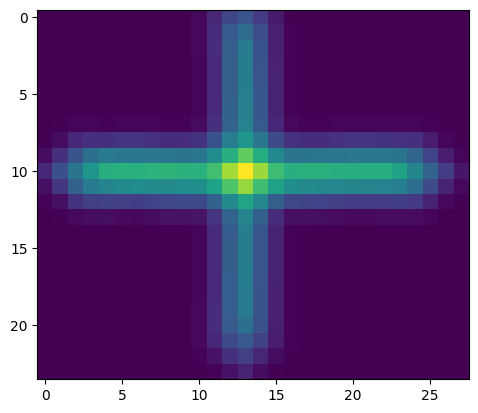

In [30]:
out = conv(img_torch)

out_map = out.squeeze().detach().numpy()
out_map = (out_map - out_map.min()) / (out_map.max() - out_map.min())

plt.imshow(out_map)
plt.show()

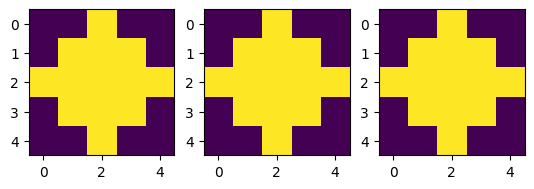

In [31]:
for i in range(3):
    m = conv[0].weight[0, i].detach().numpy()
    plt.subplot(1, 3, i + 1)
    plt.imshow(m)

Таким образом, видим, что результат свертки показывает карту, где максимальные значения соотвествуют заданному шаблону. Свертка помогает найти шаблон, заданный в ядре свертки, на входном тензоре.

## Пулинг слой

Преимущество пуллинг слоев состоит в том, что они позволяют сокращать геометрическую размерность тензора. Наращивание слоев нейронной сети позволяет увеличивать размерность векторного представления данных.


Параметры:

| Параметр | Описание |
| --- | --- |
| kernel_size | размер ядра |
| --- | --- |
| stride | шаг |
| padding | отступ |
| dilation | разреженность |

### Max/Avg Pooling

Пулинг в виде свертки. Работает по правилам обычной свертки, как ```nn.Conv2d```.


```python
nn.MaxPool2d(
    kernel_size: Union[int, Tuple[int, ...]],
    stride: Union[int, Tuple[int, ...], NoneType] = None,
    padding: Union[int, Tuple[int, ...]] = 0,
    dilation: Union[int, Tuple[int, ...]] = 1,
)
```

In [32]:
simple_block = nn.Sequential(
    nn.MaxPool2d(kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1)
)

In [33]:
out = simple_block(x)
print(x.shape, '->', out.shape)

torch.Size([1, 3, 28, 28]) -> torch.Size([1, 3, 26, 26])


### Adaptive Max/Avg Pooling

Адаптивный пулинг. Его преимущество в том, чтобы задать требуемый размер выходного тензора. Это крайне удобно для формирования заданного выхода, не зависящего от размерности входного тензора. Этот прием используется для построения нейронных сетей, которые могут принимать на вход тензоры любого размера. Эту особенность мы далее изучим в ходе реализации архитектур нейронных сетей.


```python
nn.AdaptiveMaxPool2d(
    output_size: Union[int, NoneType, Tuple[Union[int, NoneType], ...]],
    return_indices: bool = False,
) -> None
```

In [34]:
simple_block = nn.Sequential(
    nn.AdaptiveMaxPool2d(output_size=(10, 10))
)

In [35]:
out = simple_block(x)
print(x.shape, '->', out.shape)

torch.Size([1, 3, 28, 28]) -> torch.Size([1, 3, 10, 10])


In [36]:
x = torch.rand((bs, dim, 512, 512))

out = simple_block(x)
print(x.shape, '->', out.shape)

torch.Size([1, 3, 512, 512]) -> torch.Size([1, 3, 10, 10])


### Conv + Pooling + ReLU + Linear = CNN

In [37]:
simple_block = nn.Sequential(
    nn.Conv2d(in_channels=dim,
              out_channels=10,
              kernel_size=5,
              stride=1,
              padding=0,
              dilation=1,
              bias=False),
    nn.AdaptiveMaxPool2d(output_size=(1, 1)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=10, out_features=2)
)

In [38]:
x = torch.rand((bs, dim, h, w))

logit = simple_block(x)
print(x.shape, '->', logit.shape)

torch.Size([1, 3, 28, 28]) -> torch.Size([1, 2])


In [39]:
prob = torch.softmax(logit, dim=1)  # convert to probabilities
prob

tensor([[0.6402, 0.3598]], grad_fn=<SoftmaxBackward0>)

## Нормализация (Batch Norm)

[Оригинальная статья](https://arxiv.org/abs/1502.03167) - Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift


$y= \frac{x−E[x]}{\sqrt{Var[x]+ϵ}}*γ+β$


Параметры:

| Параметр | Описание |
| --- | --- |
| num_features | размер входа |
| --- | --- |
| momentum | параметр вычисления моментов |
| affine | обучение |

In [40]:
BatchNorm2d = nn.BatchNorm2d(3)
BatchNorm2d = nn.BatchNorm2d(3, affine=False)
out = BatchNorm2d(x)

print(x.shape, '->', out.shape)

torch.Size([1, 3, 28, 28]) -> torch.Size([1, 3, 28, 28])


## Cлои исключения (dropout)

[Dropout; Strivastava, Hinton et al.](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)


Параметры:

| Параметр | Описание |
| --- | --- |
| p | вероятность применения |
| inplace | менять ли входное значение |

In [41]:
Dropout2d = nn.Dropout2d(p=0.2)
out = Dropout2d(x)

print(x.shape, '->', out.shape)

torch.Size([1, 3, 28, 28]) -> torch.Size([1, 3, 28, 28])


## Построение примитивной модели

In [42]:
class CNN(nn.Module):
    def __init__(self, in_ch, n_classes):
        super(CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, stride=1, padding=0, dilation=1,
                               bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, dilation=1,
                   bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(5, 5)),
        )

        self.neck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5 * 5 * 32, 100),  # output_size * channels
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(100, n_classes, bias=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        out = self.neck(x)

        return out

In [43]:
class Net(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_ch, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 8 * 8, out_ch)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        out = self.linear_layers(x)
        return out

In [44]:
model = Net(3, 15)
x = torch.ones(2, 3, 32, 32)
out = model(x)

print(out.shape)

torch.Size([2, 15])


In [45]:
def init_scratch_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

In [46]:
model.apply(init_scratch_weights)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=15, bias=True)
  )
)

## Отображение архитектуры

In [48]:
from torchinfo import summary

In [49]:
batch_size = 12
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [12, 15]                  --
├─Sequential: 1-1                        [12, 4, 8, 8]             --
│    └─Conv2d: 2-1                       [12, 4, 32, 32]           112
│    └─BatchNorm2d: 2-2                  [12, 4, 32, 32]           8
│    └─ReLU: 2-3                         [12, 4, 32, 32]           --
│    └─MaxPool2d: 2-4                    [12, 4, 16, 16]           --
│    └─Conv2d: 2-5                       [12, 4, 16, 16]           148
│    └─BatchNorm2d: 2-6                  [12, 4, 16, 16]           8
│    └─ReLU: 2-7                         [12, 4, 16, 16]           --
│    └─MaxPool2d: 2-8                    [12, 4, 8, 8]             --
├─Sequential: 1-2                        [12, 15]                  --
│    └─Linear: 2-9                       [12, 15]                  3,855
Total params: 4,131
Trainable params: 4,131
Non-trainable params: 0
Total mult-add

# Обучение модели

## Настройки обучения

Воспользуемся конфигурационными файлами для сохранения информации о конфигурации процесса обучения. Задачи поиска оптимальных параметров обучения для высокой точности сводится к перебору моделей нейронных сетей, подходов к предобработке данных, размеру батча, скорости обучения и так далее. Хоршей практикой является сохранение всех параметров обучения.

Одним из способов сохранения параметров являются yaml-файлы. Это прямая аналогия с ```json```, однако yaml имеет преимущества с точки зрения читаемости. В питоне с ними можно работать через пакет ```yaml```.

In [50]:
# создадим примитивный словарь гипер-параметров обучения
hyp_params = {}

hyp_params['batch_size'] = 12
hyp_params['lr'] = 0.003
hyp_params['epochs'] = 3
hyp_params['weight_decay'] = 0.004
hyp_params['n_workers'] = 0
hyp_params['seed'] = 42

In [51]:
# сохраним
simple_hyp_params_path = 'test_hyp.yaml'
with open(simple_hyp_params_path, 'w') as f:
    yaml.dump(hyp_params, f)

Преимущество yaml-файлов перед json в возможности комментирования внутри файла. За счет этого повышается читаемость метаданных и документации. Таким образом, вы можете сохранять конфигурацию обучения, чтобы анализировать полученные результаты обучения от гиперпараметров.

```yaml
batch_size: 64
lr: 0.003  # inital learning rate
epochs: 3
weight_decay: 0.004
n_workers: 0

seed: 42
```

In [52]:
# откроем сохраненный файл с кофигуарцией параметров обучения
simple_hyp_params_path = 'test_hyp.yaml'
with open(simple_hyp_params_path) as f:
    hyp_params = yaml.load(f, Loader=yaml.FullLoader)

In [53]:
# отобразим изменения
hyp_params

{'batch_size': 12,
 'epochs': 3,
 'lr': 0.003,
 'n_workers': 0,
 'seed': 42,
 'weight_decay': 0.004}

In [54]:
# обращение в переменным по ключу - аналогично словарю
hyp_params['epochs']

3

## Примитивный класс обучения

In [63]:
class BaseTrainProcess:
    def __init__(self, hyp):
        self.best_loss = 1e100
        self.best_acc = 0.0
        self.current_epoch = -1
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.hyp = hyp

        self.lr_scheduler: Optional[torch.optim.lr_scheduler] = None
        self.model: Optional[torch.nn.modules] = None
        self.optimizer: Optional[torch.optim] = None
        self.criterion: Optional[torch.nn.modules] = None

        self.train_loader: Optional[Dataloader] = None
        self.valid_loader: Optional[Dataloader] = None

        self.init_params()

    def _init_data(self):

        train_dataset = CustomDataset(X_train, y_train, class_names, transform_augment=None)
        valid_dataset = CustomDataset(X_val, y_val, class_names, transform_augment=None)

        self.train_loader = DataLoader(train_dataset,
                                       batch_size=self.hyp['batch_size'],
                                       shuffle=True,
                                       num_workers=self.hyp['n_workers'])

        self.valid_loader = DataLoader(valid_dataset,
                                     batch_size=self.hyp['batch_size'],
                                     shuffle=True,
                                     num_workers=self.hyp['n_workers'])

    def _init_model(self):
        self.model = Net(3, 10)
        self.model.apply(init_scratch_weights)
        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hyp['lr'],
                                         weight_decay=self.hyp['weight_decay'])

        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min')

    def init_params(self):
        self._init_data()
        self._init_model()

    def save_checkpoint(self, loss_valid, path):
        if loss_val[1] >= self.best_acc:
            self.best_acc = loss_valid[1]
            self.save_model(path)

        if loss_val[0] <= self.best_loss:
            self.best_loss = loss_valid[0]

    def train_step(self):
        self.model.train()
        self.optimizer.zero_grad()
        self.model.zero_grad()

        cum_loss = 0.0
        cum_acc = 0.0

        proc_loss = 0.0
        proc_acc = 0.0

        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader),
                    desc=f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (images, labels) in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            with torch.set_grad_enabled(True):
                logit = self.model(images)
                loss = self.criterion(logit, labels)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.model.zero_grad()

            cur_loss = loss.detach().cpu().numpy()
            prob, pred = torch.softmax(logit.detach(), dim=1).topk(k=1)
            acc = f1_score(labels.cpu().numpy(), pred.cpu().numpy(), average='macro')
            cum_acc += acc

            cum_loss += cur_loss

            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)
            proc_acc = (proc_acc * idx + acc) / (idx + 1)

            s = f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}, F1: {proc_acc:4.3f}, BCE: {proc_loss:4.3f}'
            pbar.set_description(s)

        cum_loss /= len(self.train_loader)
        cum_acc /= len(self.train_loader)
        return [cum_loss, cum_acc]

    def valid_step(self):
        self.model.eval()

        cum_loss = 0.0
        cum_acc = 0.0

        proc_loss = 0.0
        proc_acc = 0.0

        pbar = tqdm(enumerate(self.valid_loader), total=len(self.valid_loader),
                    desc=f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (images, labels) in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            with torch.set_grad_enabled(False):
                logit = self.model(images)
                loss = self.criterion(logit, labels)

            cur_loss = loss.detach().cpu().numpy()
            prob, pred = torch.softmax(logit.detach(), dim=1).topk(k=1)
            acc = f1_score(labels.detach().cpu().numpy(), pred.detach().cpu().numpy(), average='macro')
            cum_acc += acc

            cum_loss += cur_loss

            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)
            proc_acc = (proc_acc * idx + acc) / (idx + 1)

            s = f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}, F1: {proc_acc:4.3f}, BCE: {proc_loss:4.3f}'
            pbar.set_description(s)

        cum_loss /= len(self.valid_loader)
        cum_acc /= len(self.valid_loader)
        return [cum_loss, cum_acc]

    def run(self):
        train_losses = []
        valid_losses = []

        for epoch in range(self.hyp['epochs']):
            self.current_epoch = epoch

            loss_train = self.train_step()
            train_losses.append(loss_train)
            self.lr_scheduler.step(loss_train[0])

            loss_valid = self.valid_step()
            valid_losses.append(loss_valid)

        torch.cuda.empty_cache()

        return train_losses, valid_losses

In [64]:
set_seed(hyp_params['seed'])

train_process = BaseTrainProcess(hyp=hyp_params)

losses = train_process.run()

Valid 2/2, F1: 0.401, BCE: 1.438: 100%|██████████| 834/834 [00:04<00:00, 197.47it/s]


## Примитивная визуализация результатов обучения

In [65]:
train_losses, valid_losses = losses
train_losses = np.array(train_losses).T
valid_losess = np.array(valid_losses).T

In [68]:
def plot_losses(train_losses, valid_losess):

    plt.figure(figsize=(6.4 * 2, 4.8 * 1))

    plt.subplot(121)
    plt.plot(train_losses[0, :], color='black', label='train')
    plt.plot(valid_losess[0, :], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('CrossEntropyLoss')
    plt.legend()

    plt.subplot(122)
    plt.plot(train_losses[1, :], color='black', label='train')
    plt.plot(valid_losess[1, :], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('F1')
    plt.legend()

    plt.tight_layout()

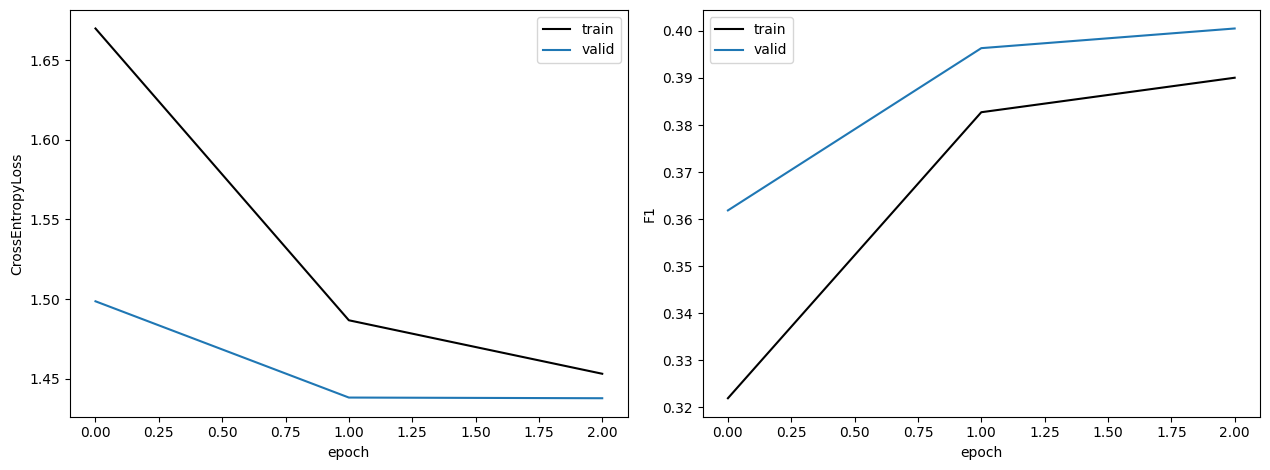

In [69]:
plot_losses(train_losses, valid_losess)

In [70]:
test_accuracy = np.max(valid_losess[1, :])

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
  test accuracy:		40.05 %


## Сохранение лучшей модели

Сохранение модели в торче не позволяет сохранить всю архитектуру вместе в весами обученных параметров. То есть загрузка модели происходит в несколько этапов
1. Загрузить модель (```nn.Module```), определив все параметры типа количества классов на выходе, размер входа и прочее
2. Загрузить веса

Для того, чтобы повысить воспроизводимость и интерпретацию результатов, хорошей практикой является сохранять все, что может быть связано с моделью: количество классов, название модели, эксперимента, время создания, размер изображений на обучении, кодировку классов и прочее. Все эти вещи потом помогут в случае, если все запутается.

Пример словаря для сохранения:
```python
save_params = {
    'exp_name': args.save_dir.stem,
    'model_type': args.model_type,
    'encoder_name': args.encoder_name,
    'model_state_dict': self.model.state_dict(),
    'optimizer_state_dict': self.optimizer.state_dict(),
    'label_list': tuple(self.cls2idx.keys()),
    'num_class': self.data['n_classes'],
    'image_size': np.fromstring(self.data['image_size'], sep=',', dtype=int),
    'valid_list': self.val_database.data_fname_list,
    'ni': self.ni,
    'loss': self.best_loss,
    'acc': self.best_acc,
    'save_time': strftime("%Y-%m-%d %H_%M_%S", gmtime())
}
```

In [71]:
from time import gmtime, strftime

In [72]:
# создадим примитивную функцию для логирования
def save_model(model, path):
    save_params = {
        'model_state_dict': model.state_dict(),  # веса модели
        'save_time': strftime("%Y-%m-%d %H_%M_%S", gmtime())
    }
    torch.save(save_params, path)

In [73]:
save_model_path = 'checkpoint.pt'

save_model(train_process.model, save_model_path)

Загрузим и проверим, что получилось сохранить

In [74]:
save_model_path = 'checkpoint.pt'

model = Net(3, 10)

# загрузим модель
checkpoint = torch.load(save_model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])  # необученная модель

<All keys matched successfully>

In [75]:
dummy_x = torch.rand((2, 3, 32, 32))

model.eval()
out_1 = model(dummy_x)

train_process.model.to('cpu')
train_process.model.eval()
out_2 = train_process.model(dummy_x)

In [76]:
np.isclose(out_1.detach().cpu().numpy(),
           out_2.detach().cpu().numpy(),
           rtol=1e-5, atol=1e-6).all()

np.True_